In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
# Создаем объект для токенизапции
tokenizer = Tokenizer(num_words=10000)

data = open('MasterAndMargarita.txt').read()

#Читаем текст
corpus = data.lower().split("\n")

In [3]:
corpus[:10]

['однажды весною, в час небывало жаркого заката, в москве, на патриарших прудах, появились два гражданина. первый из них, одетый в летнюю серенькую пару, был маленького роста, упитан, лыс, свою приличную шляпу пирожком нес в руке, а на хорошо выбритом лице его помещались сверхъестественных размеров очки в черной роговой оправе. второй – плечистый, рыжеватый, вихрастый молодой человек в заломленной на затылок клетчатой кепке – был в ковбойке, жеваных белых брюках и в черных тапочках.',
 '',
 'первый был не кто иной, как михаил александрович берлиоз, председатель правления одной из крупнейших московских литературных ассоциаций, сокращенно именуемой массолит, и редактор толстого художественного журнала, а молодой спутник его – поэт иван николаевич понырев, пишущий под псевдонимом бездомный.',
 '',
 'попав в тень чуть зеленеющих лип, писатели первым долгом бросились к пестро раскрашенной будочке с надписью «пиво и воды».',
 '',
 'да, следует отметить первую странность этого страшного майск

In [4]:
tokenizer.fit_on_texts( corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [5]:
label.shape

(3454, 1637)

In [6]:
callback = EarlyStopping( monitor = 'val_accuracy', patience = 10) # создаем обратный вызов - calback - тут "Ранний останов"

In [7]:
model = Sequential()
model.add(Embedding(total_words, 512, input_length = max_sequence_len-1))  # вложение тренируемое для перехода от слова к его векторному коду 
# на вход вложения (эмбединга) передаем вектор словарь (длина равна словарю, вектор разреженный)), на выход строим вектор из n (тут 256) координат - он плотный
#model.add(Bidirectional(LSTM(50, return_sequences = True)))

model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(total_words/2, activation = 'relu', kernel_regularizer = regularizers.l2(0.001)))
model.add(Dense(total_words, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 276, 512)          838144    
                                                                 
 lstm (LSTM)                 (None, 256)               787456    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 818)               210226    
                                                                 
 dense_1 (Dense)             (None, 1637)              1340703   
                                                                 
Total params: 3,176,529
Trainable params: 3,176,529
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
 history = model.fit(predictors, label, epochs=100, validation_split=0.2, callbacks=[callback],verbose=1)

Epoch 1/100
87/87 [==============================] - 169s 2s/step - loss: 7.1627 - accuracy: 0.0402 - val_loss: 6.9698 - val_accuracy: 0.0391
Epoch 2/100
87/87 [==============================] - 168s 2s/step - loss: 6.6015 - accuracy: 0.0438 - val_loss: 7.0894 - val_accuracy: 0.0391
Epoch 3/100
87/87 [==============================] - 190s 2s/step - loss: 6.3425 - accuracy: 0.0380 - val_loss: 7.2492 - val_accuracy: 0.0420
Epoch 4/100
87/87 [==============================] - 217s 2s/step - loss: 6.1577 - accuracy: 0.0460 - val_loss: 7.5261 - val_accuracy: 0.0767
Epoch 5/100
87/87 [==============================] - 308s 4s/step - loss: 5.9687 - accuracy: 0.0536 - val_loss: 7.6725 - val_accuracy: 0.0753
Epoch 6/100
87/87 [==============================] - 306s 4s/step - loss: 5.7054 - accuracy: 0.0637 - val_loss: 7.8567 - val_accuracy: 0.0622
Epoch 7/100
87/87 [==============================] - 288s 3s/step - loss: 5.3830 - accuracy: 0.0803 - val_loss: 8.3550 - val_accuracy: 0.0492
Epoch 

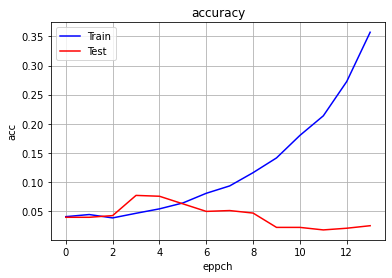

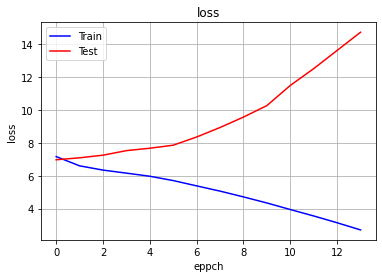

In [9]:
acc = history.history['accuracy']
acc_v = history.history['val_accuracy']
loss = history.history['loss']
loss_v = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Train')
plt.plot(epochs, acc_v, 'r', label='Test')
plt.legend()
plt.title('accuracy')
plt.xlabel('eppch')
plt.ylabel('acc')
plt.grid()
plt.figure()

plt.plot(epochs, loss, 'b', label='Train')
plt.plot(epochs, loss_v, 'r', label='Test')
plt.title('loss')
plt.xlabel('eppch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

In [10]:
# начальная строка
seed_text = "Быть или не быть"
next_words = 10

# строим последовательность + новое предсказание  
for _ in range(next_words):
  # текущая последовательность (токенизация и дополнение)
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  print(token_list)
  token_list = pad_sequences([token_list], maxlen = max_sequence_len-1, padding = 'pre')
  # делаем предсказание 
  predicted = model.predict(token_list, verbose=0)
  predict_ = np.argmax(predicted)
  output_word = ""
  print(predict_)
  # добавим новое слово в последовательность
  for word, index in tokenizer.word_index.items():
    if index == predict_:
      output_word = word
      break
  seed_text += " " + output_word

print(seed_text)

[81, 268, 4, 81]
1
[81, 268, 4, 81, 1]
88
[81, 268, 4, 81, 1, 88]
183
[81, 268, 4, 81, 1, 88, 183]
1326
[81, 268, 4, 81, 1, 88, 183, 1326]
1014
[81, 268, 4, 81, 1, 88, 183, 1326, 1014]
2
[81, 268, 4, 81, 1, 88, 183, 1326, 1014, 2]
54
[81, 268, 4, 81, 1, 88, 183, 1326, 1014, 2, 54]
700
[81, 268, 4, 81, 1, 88, 183, 1326, 1014, 2, 54, 700]
701
[81, 268, 4, 81, 1, 88, 183, 1326, 1014, 2, 54, 700, 701]
3
Быть или не быть – совершенно улыбнувшись выговорить скамейки и очень умело указывал в


In [11]:
y_p=model.predict(token_list)

1/1 [==============================] - 0s 72ms/step


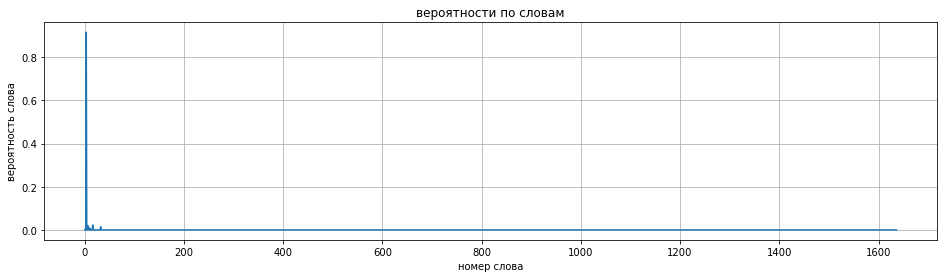

In [12]:
plt.figure(figsize=(16,4))
plt.plot(y_p[0,:])
plt.xlabel('номер слова')
plt.ylabel('вероятность слова')
plt.title('вероятности по словам')
plt.grid('on')
plt.show()

In [13]:
seed_text = "Быть или не быть"
  
for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  print(token_list)
  token_list = pad_sequences([token_list], maxlen = max_sequence_len-1, padding='pre')
  
  output_word = ""
  y_p = model.predict(token_list)
  y_predict = y_p * np.random.random(  size = (1,y_p.shape[1]))
  predicted_ind = np.argmax(y_predict,axis = 1)
  for word, index in tokenizer.word_index.items():
    if index == predicted_ind:
      output_word = word
      break
  seed_text += " " + output_word

print(seed_text)

[81, 268, 4, 81]
1/1 [==============================] - 0s 62ms/step
[81, 268, 4, 81, 1]
1/1 [==============================] - 0s 63ms/step
[81, 268, 4, 81, 1, 14]
1/1 [==============================] - 0s 56ms/step
[81, 268, 4, 81, 1, 14, 14]
1/1 [==============================] - 0s 73ms/step
[81, 268, 4, 81, 1, 14, 14, 7]
1/1 [==============================] - 0s 63ms/step
[81, 268, 4, 81, 1, 14, 14, 7, 7]
1/1 [==============================] - 0s 42ms/step
[81, 268, 4, 81, 1, 14, 14, 7, 7, 14]
1/1 [==============================] - 0s 70ms/step
[81, 268, 4, 81, 1, 14, 14, 7, 7, 14, 14]
1/1 [==============================] - 0s 60ms/step
[81, 268, 4, 81, 1, 14, 14, 7, 7, 14, 14, 4]
1/1 [==============================] - 0s 59ms/step
[81, 268, 4, 81, 1, 14, 14, 7, 7, 14, 14, 4, 1298]
1/1 [==============================] - 0s 82ms/step
Быть или не быть – иностранец иностранец он он иностранец иностранец не столько поразило


In [15]:
def func_test(neuronEmb, neuronLSTM, l2, optimizer):
    print(f"{neuronEmb=}")
    print(f"{neuronLSTM=}")
    print(f"{l2=}")
    print(f"{optimizer=}")
    
    model = Sequential()
    model.add(Embedding(total_words, neuronEmb, input_length = max_sequence_len-1))

    model.add(LSTM(neuronLSTM))
    model.add(Dropout(0.2))
    model.add(Dense(total_words/2, activation = 'relu', kernel_regularizer = regularizers.l2(l2)))
    model.add(Dense(total_words, activation = 'softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    
    history = model.fit(predictors, label, epochs=100, validation_split=0.2, callbacks=[callback], verbose=1)
    
    acc = history.history['accuracy']
    acc_v = history.history['val_accuracy']
    loss = history.history['loss']
    loss_v = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Train')
    plt.plot(epochs, acc_v, 'r', label='Test')
    plt.legend()
    plt.title('accuracy')
    plt.xlabel('eppch')
    plt.ylabel('acc')
    plt.grid()
    plt.figure()

    plt.plot(epochs, loss, 'b', label='Train')
    plt.plot(epochs, loss_v, 'r', label='Test')
    plt.title('loss')
    plt.xlabel('eppch')
    plt.ylabel('loss')
    plt.legend()
    plt.grid()
    plt.show()
    
    # начальная строка
    seed_text = "Быть или не быть"
    next_words = 10

    # строим последовательность + новое предсказание  
    for _ in range(next_words):
      # текущая последовательность (токенизация и дополнение)
      token_list = tokenizer.texts_to_sequences([seed_text])[0]
      token_list = pad_sequences([token_list], maxlen = max_sequence_len-1, padding = 'pre')
      # делаем предсказание 
      predicted = model.predict(token_list, verbose=0)
      predict_ = np.argmax(predicted)
      output_word = ""
      # добавим новое слово в последовательность
      for word, index in tokenizer.word_index.items():
        if index == predict_:
          output_word = word
          break
      seed_text += " " + output_word

    print(seed_text)
    
    y_p=model.predict(token_list)
    
    plt.figure(figsize=(16,4))
    plt.plot(y_p[0,:])
    plt.xlabel('номер слова')
    plt.ylabel('вероятность слова')
    plt.title('вероятности по словам')
    plt.grid('on')
    plt.show()
  
    for _ in range(next_words):
      token_list = tokenizer.texts_to_sequences([seed_text])[0]
      token_list = pad_sequences([token_list], maxlen = max_sequence_len-1, padding='pre')

      output_word = ""
      y_p = model.predict(token_list)
      y_predict = y_p * np.random.random(size = (1, y_p.shape[1]))
      predicted_ind = np.argmax(y_predict,axis = 1)
      for word, index in tokenizer.word_index.items():
        if index == predicted_ind:
          output_word = word
          break
      seed_text += " " + output_word

    print(seed_text)

In [16]:
neurons = [[256, 128], [512, 256]]
l2s = [0.01, 0.001]
optimizers = ["adam", "NAdam"]

neuronEmb=256
neuronLSTM=128
l2=0.01
optimizer='adam'
Epoch 1/100
87/87 [==============================] - 24s 257ms/step - loss: 7.7541 - accuracy: 0.0376 - val_loss: 7.0950 - val_accuracy: 0.0738
Epoch 2/100
87/87 [==============================] - 31s 355ms/step - loss: 6.6305 - accuracy: 0.0362 - val_loss: 7.0835 - val_accuracy: 0.0738
Epoch 3/100
87/87 [==============================] - 31s 352ms/step - loss: 6.3343 - accuracy: 0.0405 - val_loss: 7.2974 - val_accuracy: 0.0738
Epoch 4/100
87/87 [==============================] - 32s 373ms/step - loss: 6.1767 - accuracy: 0.0405 - val_loss: 7.3914 - val_accuracy: 0.0391
Epoch 5/100
87/87 [==============================] - 32s 373ms/step - loss: 6.0958 - accuracy: 0.0434 - val_loss: 7.8634 - val_accuracy: 0.0391
Epoch 6/100
87/87 [==============================] - 33s 378ms/step - loss: 6.0329 - accuracy: 0.0376 - val_loss: 8.0028 - val_accuracy: 0.0434
Epoch 7/100
87/87 [==============================] - 32s 374ms/step - loss: 5.9501

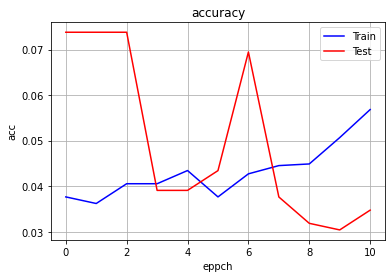

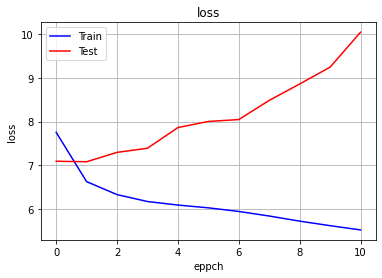

Быть или не быть – в том что в том но и может но
1/1 [==============================] - 0s 49ms/step


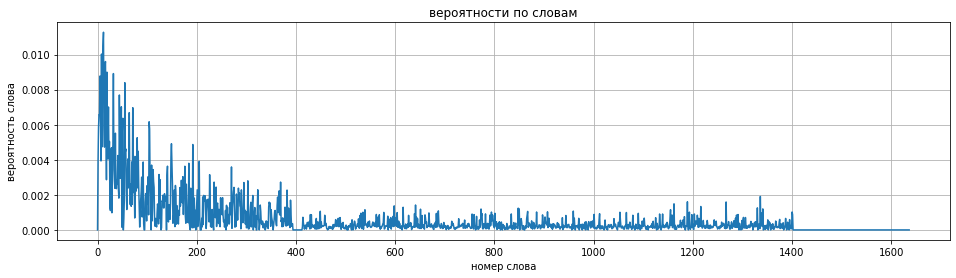

1/1 [==============================] - 0s 53ms/step
Быть или не быть – в том что в том но и может но с ним то в может но как с том но
neuronEmb=256
neuronLSTM=128
l2=0.01
optimizer='NAdam'
Epoch 1/100
87/87 [==============================] - 38s 398ms/step - loss: 7.8403 - accuracy: 0.0409 - val_loss: 7.1125 - val_accuracy: 0.0391
Epoch 2/100
87/87 [==============================] - 33s 381ms/step - loss: 6.6822 - accuracy: 0.0373 - val_loss: 7.5109 - val_accuracy: 0.0391
Epoch 3/100
87/87 [==============================] - 32s 371ms/step - loss: 6.3804 - accuracy: 0.0449 - val_loss: 7.2350 - val_accuracy: 0.0738
Epoch 4/100
87/87 [==============================] - 33s 377ms/step - loss: 6.2154 - accuracy: 0.0445 - val_loss: 7.3865 - val_accuracy: 0.0651
Epoch 5/100
87/87 [==============================] - 33s 377ms/step - loss: 6.0863 - accuracy: 0.0507 - val_loss: 7.7375 - val_accuracy: 0.0709
Epoch 6/100
87/87 [==============================] - 32s 372ms/step - loss: 5.9556 - accura

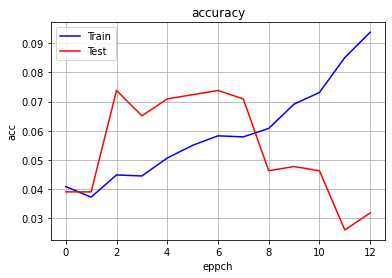

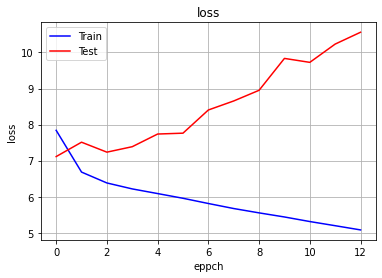

Быть или не быть – – иностранец берлиоз – иностранец ответил берлиоз – –
1/1 [==============================] - 0s 33ms/step


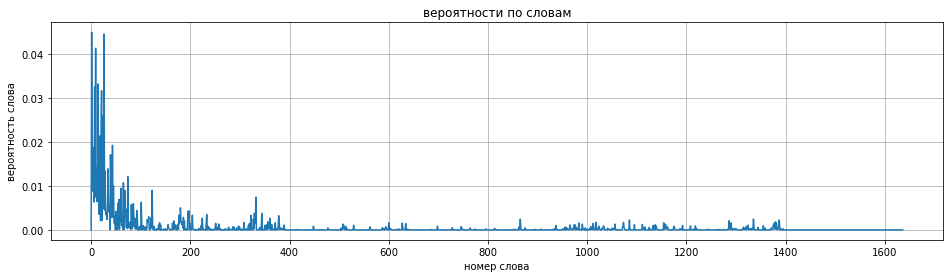

1/1 [==============================] - 0s 35ms/step
Быть или не быть – – иностранец берлиоз – иностранец ответил берлиоз – – иностранец берлиоз – воскликнул ответил – – подумал – подумал
neuronEmb=256
neuronLSTM=128
l2=0.001
optimizer='adam'
Epoch 1/100
87/87 [==============================] - 34s 369ms/step - loss: 7.1031 - accuracy: 0.0394 - val_loss: 6.9305 - val_accuracy: 0.0738
Epoch 2/100
87/87 [==============================] - 33s 378ms/step - loss: 6.5652 - accuracy: 0.0420 - val_loss: 7.0256 - val_accuracy: 0.0535
Epoch 3/100
87/87 [==============================] - 33s 380ms/step - loss: 6.3386 - accuracy: 0.0423 - val_loss: 7.3416 - val_accuracy: 0.0738
Epoch 4/100
87/87 [==============================] - 33s 378ms/step - loss: 6.1809 - accuracy: 0.0518 - val_loss: 7.6135 - val_accuracy: 0.0463
Epoch 5/100
87/87 [==============================] - 33s 380ms/step - loss: 6.0383 - accuracy: 0.0543 - val_loss: 7.5776 - val_accuracy: 0.0680
Epoch 6/100
87/87 [===================

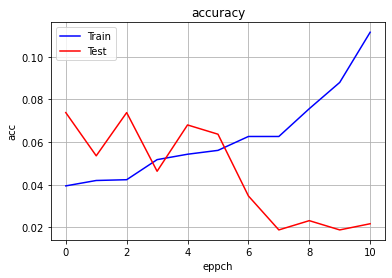

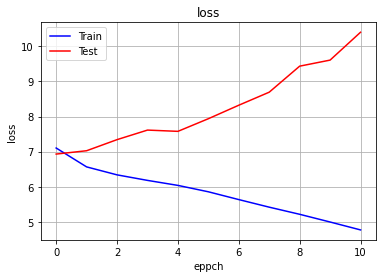

Быть или не быть – иностранец не иностранец не иностранец не было не было
1/1 [==============================] - 0s 39ms/step


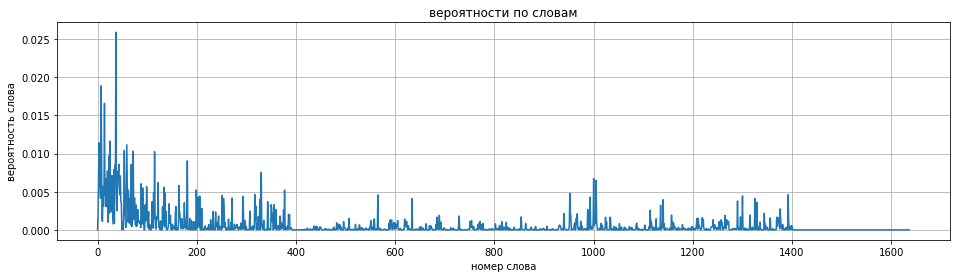

1/1 [==============================] - 0s 52ms/step
Быть или не быть – иностранец не иностранец не иностранец не было не было не в всей шла бога с нем об самим бога
neuronEmb=256
neuronLSTM=128
l2=0.001
optimizer='NAdam'
Epoch 1/100
87/87 [==============================] - 40s 427ms/step - loss: 7.0507 - accuracy: 0.0391 - val_loss: 6.9116 - val_accuracy: 0.0145
Epoch 2/100
87/87 [==============================] - 34s 395ms/step - loss: 6.5893 - accuracy: 0.0423 - val_loss: 7.1361 - val_accuracy: 0.0391
Epoch 3/100
87/87 [==============================] - 35s 407ms/step - loss: 6.3788 - accuracy: 0.0463 - val_loss: 7.5899 - val_accuracy: 0.0564
Epoch 4/100
87/87 [==============================] - 34s 388ms/step - loss: 6.1796 - accuracy: 0.0510 - val_loss: 7.5490 - val_accuracy: 0.0666
Epoch 5/100
87/87 [==============================] - 34s 391ms/step - loss: 5.9718 - accuracy: 0.0557 - val_loss: 7.7585 - val_accuracy: 0.0709
Epoch 6/100
87/87 [==============================] - 34s 39

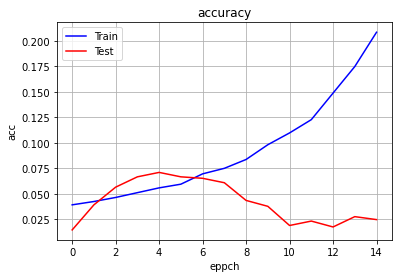

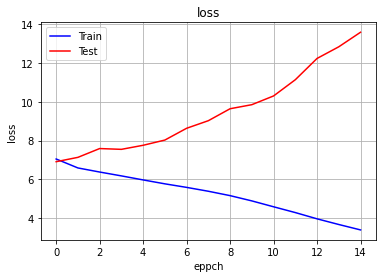

Быть или не быть берлиоз – решил берлиоз – подумал бездомный это так так
1/1 [==============================] - 0s 50ms/step


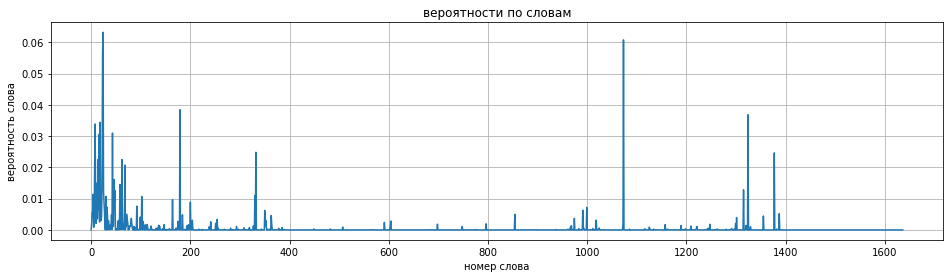

1/1 [==============================] - 0s 21ms/step
Быть или не быть берлиоз – решил берлиоз – подумал бездомный это так так говорить открыл отвратительное божия произвел русски » – и громко
neuronEmb=512
neuronLSTM=256
l2=0.01
optimizer='adam'
Epoch 1/100
87/87 [==============================] - 253s 3s/step - loss: 8.2743 - accuracy: 0.0347 - val_loss: 7.2062 - val_accuracy: 0.0738
Epoch 2/100
87/87 [==============================] - 282s 3s/step - loss: 6.6629 - accuracy: 0.0416 - val_loss: 7.0767 - val_accuracy: 0.0738
Epoch 3/100
87/87 [==============================] - 287s 3s/step - loss: 6.3182 - accuracy: 0.0413 - val_loss: 7.3240 - val_accuracy: 0.0680
Epoch 4/100
87/87 [==============================] - 289s 3s/step - loss: 6.1645 - accuracy: 0.0405 - val_loss: 7.5306 - val_accuracy: 0.0463
Epoch 5/100
87/87 [==============================] - 290s 3s/step - loss: 6.0706 - accuracy: 0.0445 - val_loss: 7.6904 - val_accuracy: 0.0666
Epoch 6/100
87/87 [==========================

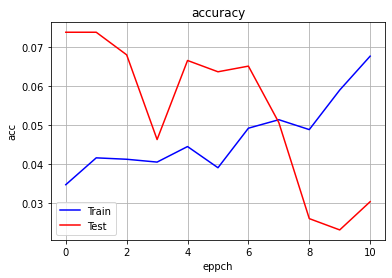

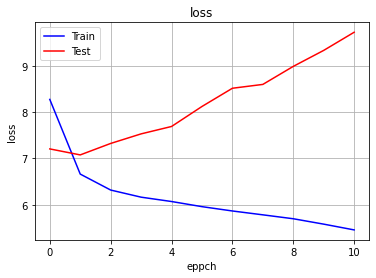

Быть или не быть – – он иностранец берлиоз – он иностранец берлиоз –
1/1 [==============================] - 0s 48ms/step


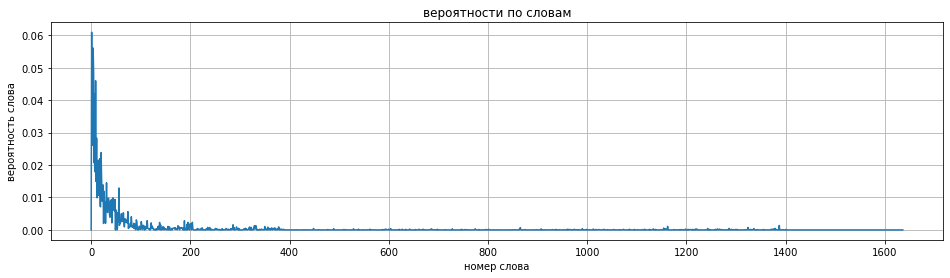

1/1 [==============================] - 0s 64ms/step
Быть или не быть – – он иностранец берлиоз – он иностранец берлиоз – он это берлиоз что иностранец – не иностранец как не
neuronEmb=512
neuronLSTM=256
l2=0.01
optimizer='NAdam'
Epoch 1/100
87/87 [==============================] - 314s 4s/step - loss: 8.4465 - accuracy: 0.0347 - val_loss: 7.6895 - val_accuracy: 0.0463
Epoch 2/100
87/87 [==============================] - 311s 4s/step - loss: 6.7650 - accuracy: 0.0416 - val_loss: 7.0836 - val_accuracy: 0.0753
Epoch 3/100
87/87 [==============================] - 306s 4s/step - loss: 6.3779 - accuracy: 0.0496 - val_loss: 7.1350 - val_accuracy: 0.0680
Epoch 4/100
87/87 [==============================] - 285s 3s/step - loss: 6.1522 - accuracy: 0.0521 - val_loss: 7.3672 - val_accuracy: 0.0724
Epoch 5/100
87/87 [==============================] - 293s 3s/step - loss: 5.9761 - accuracy: 0.0547 - val_loss: 7.8408 - val_accuracy: 0.0666
Epoch 6/100
87/87 [==============================] - 310s 4s/

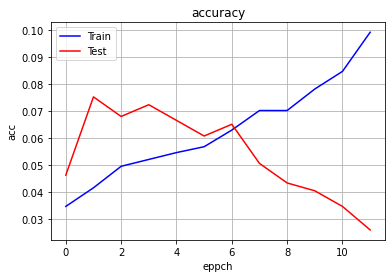

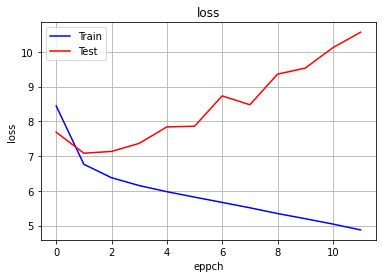

Быть или не быть – берлиоз – бездомный бездомный бездомный иностранец спросил как говорить
1/1 [==============================] - 0s 81ms/step


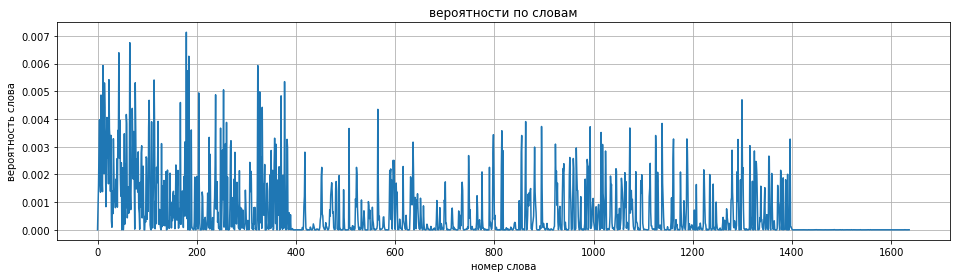

1/1 [==============================] - 0s 53ms/step
Быть или не быть – берлиоз – бездомный бездомный бездомный иностранец спросил как говорить то то то то то то по том что он
neuronEmb=512
neuronLSTM=256
l2=0.001
optimizer='adam'
Epoch 1/100
87/87 [==============================] - 303s 3s/step - loss: 7.1901 - accuracy: 0.0333 - val_loss: 7.0062 - val_accuracy: 0.0521
Epoch 2/100
87/87 [==============================] - 306s 4s/step - loss: 6.6003 - accuracy: 0.0431 - val_loss: 7.1539 - val_accuracy: 0.0463
Epoch 3/100
87/87 [==============================] - 310s 4s/step - loss: 6.3418 - accuracy: 0.0409 - val_loss: 7.4130 - val_accuracy: 0.0564
Epoch 4/100
87/87 [==============================] - 309s 4s/step - loss: 6.1621 - accuracy: 0.0503 - val_loss: 7.4934 - val_accuracy: 0.0709
Epoch 5/100
87/87 [==============================] - 310s 4s/step - loss: 5.9946 - accuracy: 0.0536 - val_loss: 7.8154 - val_accuracy: 0.0695
Epoch 6/100
87/87 [==============================] - 311s 4s

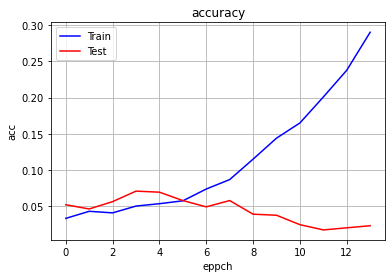

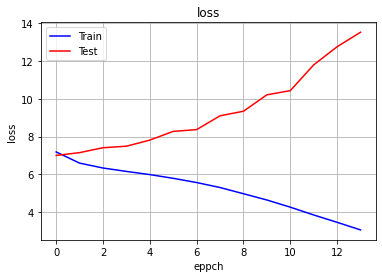

Быть или не быть – подумал иностранец – говорил берлиоз и нахмурился неизвестный вы
1/1 [==============================] - 0s 65ms/step


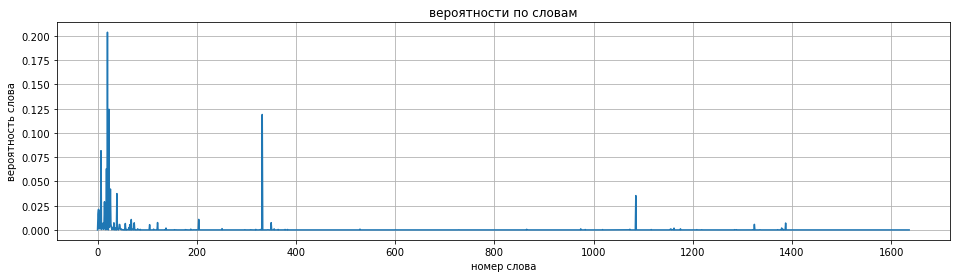

1/1 [==============================] - 0s 87ms/step
Быть или не быть – подумал иностранец – говорил берлиоз и нахмурился неизвестный вы левый зеленый бытия мысль об иисусе о казни человек не
neuronEmb=512
neuronLSTM=256
l2=0.001
optimizer='NAdam'
Epoch 1/100
87/87 [==============================] - 401s 5s/step - loss: 7.1581 - accuracy: 0.0362 - val_loss: 6.9145 - val_accuracy: 0.0738
Epoch 2/100
87/87 [==============================] - 382s 4s/step - loss: 6.6325 - accuracy: 0.0481 - val_loss: 7.0865 - val_accuracy: 0.0579
Epoch 3/100
87/87 [==============================] - 383s 4s/step - loss: 6.3578 - accuracy: 0.0547 - val_loss: 7.3453 - val_accuracy: 0.0622
Epoch 4/100
87/87 [==============================] - 402s 5s/step - loss: 6.1103 - accuracy: 0.0575 - val_loss: 7.5635 - val_accuracy: 0.0622
Epoch 5/100
87/87 [==============================] - 415s 5s/step - loss: 5.8452 - accuracy: 0.0637 - val_loss: 7.9178 - val_accuracy: 0.0695
Epoch 6/100
87/87 [========================

In [ ]:
for neuron in neurons:
    for l2 in l2s:
        for optimizer in optimizers:
            func_test(neuron[0], neuron[1], l2, optimizer)